In [1]:
import torch
import pandas as pd
import numpy as np
import requests
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from typing import List

# Ustawienie urządzenia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/home/karotka/sem10/cuda/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Ładowanie modelu do embeddingów
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)


In [3]:
def get_embeddings(texts: List[str], tokenizer, model):
    encoded_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**encoded_inputs)
    token_embeddings = outputs.last_hidden_state
    embeddings = torch.mean(token_embeddings, dim=1)
    return embeddings.cpu().numpy()


In [4]:
# Wczytaj plik CSV
puzzles_df = pd.read_csv('puzzles_dataset.csv')  # <-- dostosuj ścieżkę jeśli trzeba

puzzles_texts = puzzles_df['puzzle'].tolist()
puzzles_answers = puzzles_df['answer'].tolist()
puzzles_difficulties = puzzles_df['difficulty'].tolist()


In [5]:
# Obliczenie embeddingów dla bazy zagadek
puzzles_embeddings = get_embeddings(puzzles_texts, tokenizer, model)


In [6]:
class ReasoningFewShotAgent:
    def __init__(self, tokenizer, model, db_texts, db_answers, db_embeddings, ollama_model="mistral", ollama_endpoint="http://localhost:11434"):
        self.tokenizer = tokenizer
        self.model = model
        self.db_texts = db_texts
        self.db_answers = db_answers
        self.db_embeddings = db_embeddings
        self.ollama_model = ollama_model
        self.ollama_endpoint = ollama_endpoint

    def get_query_embedding(self, query: str):
        return get_embeddings([query], self.tokenizer, self.model)[0]

    def retrieve_examples(self, query_embedding, top_k=3):
        similarities = cosine_similarity([query_embedding], self.db_embeddings)[0]
        top_indices = np.argsort(similarities)[-top_k:][::-1]
        examples = [(self.db_texts[i], self.db_answers[i]) for i in top_indices]
        return examples

    def build_prompt(self, examples, query):
        prompt = (
            "Jesteś agentem rozwiązującym zagadki logiczne.\n"
            "Twoim zadaniem jest rozwiązać zagadkę krok po kroku.\n\n"
            "Jeśli zagadka dotyczy porównania osób, przedmiotów lub wielkości — odpowiedź powinna być nazwą osoby lub rzeczy, a nie liczbą.\n"
            "Jeśli zagadka dotyczy obliczeń matematycznych — podaj liczbę jako odpowiedź.\n\n"
            "Podaj finalną odpowiedź w formacie: 'Odpowiedź: ...'\n\n"
            "Przykłady:\n"
        )
        for i, (ex_question, ex_answer) in enumerate(examples):
            prompt += f"{i+1}. Zagadka: {ex_question}\nOdpowiedź: {ex_answer}\n\n"
        prompt += f"Nowa zagadka:\n{query}\n"
        return prompt


    def query_ollama(self, prompt):
        response = requests.post(
            f"{self.ollama_endpoint}/api/generate",
            json={
                "model": self.ollama_model,
                "prompt": prompt,
                "stream": False
            }
        )

        if response.status_code != 200:
            raise Exception(f"Błąd komunikacji z Ollama: {response.status_code} {response.text}")

        return response.json().get('response', '').strip()

    def solve(self, query: str, top_k=3, verbose: bool = True):
        query_embedding = self.get_query_embedding(query)
        examples = self.retrieve_examples(query_embedding, top_k=top_k)
        prompt = self.build_prompt(examples, query)
        response = self.query_ollama(prompt)

        if verbose:
            print("🧠 Symulacja rozumowania agenta:\n")
            print(response)

        return response


In [7]:
# Inicjalizacja ReasoningFewShotAgenta
agent = ReasoningFewShotAgent(
    tokenizer=tokenizer,
    model=model,
    db_texts=puzzles_texts,
    db_answers=puzzles_answers,
    db_embeddings=puzzles_embeddings,
    ollama_model="mistral"  # lub "mixtral" jeśli chcesz dokładniejszy model
)

# Test na nowej zagadce
query = "Ala ma więcej cukierków niż Ola. Ola ma więcej niż Ela. Kto ma najwięcej cukierków?"
agent.solve(query, top_k=3, verbose=True)


🧠 Symulacja rozumowania agenta:

Odpowiedź: Ala


'Odpowiedź: Ala'

In [8]:
import re
from collections import defaultdict

def normalize_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.strip().lower()
    text = text.replace("odpowiedź", "").strip()
    return text

def evaluate_answers(agent, test_queries, test_answers, verbose) -> tuple:
    correct = 0
    for query, answer in zip(test_queries, test_answers):
        answer = normalize_text(answer.strip())
        if verbose:
            print(f'\n\nQuery is: {query}\t Correct answer is: {answer}')
        response = normalize_text(agent.solve(query, top_k=3, verbose = verbose).strip())
        if response == answer:
            print("Answer was correct :)")
            correct += 1
        else:
            print(f'Response:[{response}] vs answer[{answer}]')
    return correct, len(test_queries) - correct

def evaluate_agent_by_category(agent, puzzles_df, verbose = True):
    difficulties = puzzles_df['difficulty'].unique()
    
    accuracy_score = defaultdict(lambda: (int, int))
    for difficulty in difficulties:
        print(f"Processing difficulty: {difficulty}")
        category_rows = puzzles_df[puzzles_df['difficulty'] == difficulty]
        
        test_queries = category_rows["puzzle"].tolist()
        test_answers = category_rows["answer"].tolist()
        accuracy_score[difficulty] = evaluate_answers(agent, test_queries, test_answers, verbose)
        
    return accuracy_score
    
accuracies = evaluate_agent_by_category(agent, puzzles_df)

Processing difficulty: easy


Query is: Anna ma więcej jabłek niż Basia. Basia ma więcej niż Celina. Kto ma najwięcej jabłek?	 Correct answer is: anna
🧠 Symulacja rozumowania agenta:

Odpowiedź: Anna
Answer was correct :)


Query is: Tomek jest młodszy od Michała, ale starszy od Piotra. Kto jest najstarszy?	 Correct answer is: michał
🧠 Symulacja rozumowania agenta:

Odpowiedź: Michał
Answer was correct :)


Query is: Która liczba jest większa: 35 czy 53?	 Correct answer is: 53
🧠 Symulacja rozumowania agenta:

Odpowiedź: 53
Answer was correct :)


Query is: Pies waży więcej niż kot, ale mniej niż koń. Które zwierzę jest najcięższe?	 Correct answer is: koń
🧠 Symulacja rozumowania agenta:

Odpowiedź: Koń
Answer was correct :)


Query is: Jeśli dzisiaj jest wtorek, jaki dzień będzie za trzy dni?	 Correct answer is: piątek
🧠 Symulacja rozumowania agenta:

Odpowiedź: piątek
Answer was correct :)


Query is: Mama Adama ma trzech synów: Kwiatek, Motylek i...?	 Correct answer is: adam
🧠 Symulac

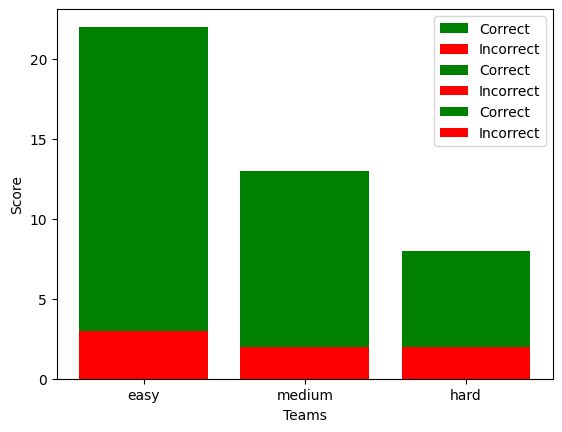

In [9]:
import matplotlib.pyplot as plt

def plot_accuracies(acc_dict: dict):
    i = 1
    for diff in acc_dict.keys():
        plt.bar(diff, acc_dict[diff][0], width = 0.8, color='g', label='Correct')
        plt.bar(diff, acc_dict[diff][1], width = 0.8, color='r', label='Incorrect')
        
    plt.xlabel("Teams")
    plt.ylabel("Score")
    plt.legend()
    plt.show()
    
plot_accuracies(accuracies)

## Few shot strategies

In [ ]:
class ChainOfThoughtAgent(ReasoningFewShotAgent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def build_prompt(self, examples, query):
        prompt = (
            "Jesteś agentem rozwiązującym zagadki logiczne.\n"
            "Twoim zadaniem jest rozwiązać zagadkę krok po kroku, pokazując swoje rozumowanie.\n\n"
            "Ważne:\n"
            "1. Najpierw przeanalizuj problem dokładnie\n"
            "2. Rozbij problem na mniejsze kroki\n"
            "3. Rozwiąż każdy krok osobno\n"
            "4. Wyciągnij ostateczny wniosek\n\n"
            "Jeśli zagadka dotyczy porównania osób, przedmiotów lub wielkości — odpowiedź powinna być nazwą osoby lub rzeczy, a nie liczbą.\n"
            "Jeśli zagadka dotyczy obliczeń matematycznych — podaj liczbę jako odpowiedź.\n\n"
            "Podaj finalną odpowiedź w formacie: 'Odpowiedź: ...'\n\n"
            "Przykłady:\n"
        )
        
        for i, (ex_question, ex_answer) in enumerate(examples):
            prompt += f"{i+1}. Zagadka: {ex_question}\nOdpowiedź: {ex_answer}\n\n"
        
        prompt += f"Nowa zagadka:\n{query}\n\nKrok po kroku rozumowanie:\n"
        return prompt

In [ ]:
class FewShotStrategies:
    @staticmethod
    def most_similar(query_embedding, db_embeddings, db_texts, db_answers, top_k=3):
        """Standard similarity-based selection (what you already have)"""
        similarities = cosine_similarity([query_embedding], db_embeddings)[0]
        top_indices = np.argsort(similarities)[-top_k:][::-1]
        return [(db_texts[i], db_answers[i]) for i in top_indices]
    
    @staticmethod
    def diverse_sampling(query_embedding, db_embeddings, db_texts, db_answers, top_k=3, diversity_factor=0.5):
        """Select diverse examples while maintaining relevance"""
        similarities = cosine_similarity([query_embedding], db_embeddings)[0]
        
        selected_indices = [np.argmax(similarities)]
        selected_embeddings = [db_embeddings[selected_indices[0]]]
        
        remaining_indices = list(set(range(len(db_embeddings))) - set(selected_indices))
        
        while len(selected_indices) < top_k and remaining_indices:
            sim_to_query = similarities[remaining_indices]
            
            sim_to_selected = cosine_similarity(
                db_embeddings[remaining_indices],
                np.array(selected_embeddings)
            )
            avg_sim_to_selected = np.mean(sim_to_selected, axis=1)
            
            combined_score = diversity_factor * sim_to_query - (1 - diversity_factor) * avg_sim_to_selected
 
            best_idx_pos = np.argmax(combined_score)
            best_idx = remaining_indices[best_idx_pos]
            

            selected_indices.append(best_idx)
            selected_embeddings.append(db_embeddings[best_idx])
            remaining_indices.remove(best_idx)
        
        return [(db_texts[i], db_answers[i]) for i in selected_indices]
    
    @staticmethod
    def difficulty_based(query_embedding, db_embeddings, db_texts, db_answers, difficulties, top_k=3, target_difficulty=None):
        """Select examples of similar difficulty level"""
        if target_difficulty is None:

            similarities = cosine_similarity([query_embedding], db_embeddings)[0]
            top_indices = np.argsort(similarities)[-5:][::-1]  # Use top 5 to vote
            difficulty_counts = {}
            for idx in top_indices:
                diff = difficulties[idx]
                difficulty_counts[diff] = difficulty_counts.get(diff, 0) + 1
            target_difficulty = max(difficulty_counts.items(), key=lambda x: x[1])[0]
        

        target_indices = [i for i, d in enumerate(difficulties) if d == target_difficulty]
        

        similarities = cosine_similarity([query_embedding], db_embeddings[target_indices])[0]

        top_k_indices = np.argsort(similarities)[-top_k:][::-1]
        selected_indices = [target_indices[i] for i in top_k_indices]
        
        return [(db_texts[i], db_answers[i]) for i in selected_indices]

In [ ]:
def create_cot_examples(agent, puzzles_df, num_examples=5):
    """Generate chain-of-thought examples using the base agent"""
    cot_examples = []
    
    for difficulty in puzzles_df['difficulty'].unique():
        category_rows = puzzles_df[puzzles_df['difficulty'] == difficulty].sample(min(2, sum(puzzles_df['difficulty'] == difficulty)))
        
        for _, row in category_rows.iterrows():
            query = row['puzzle']
            answer = row['answer']

            reasoning = agent.solve(query, verbose=False)
            

            if not reasoning.strip().endswith(answer):
                reasoning += f"\nOdpowiedź: {answer}"
                
            cot_examples.append((query, reasoning))
            
            if len(cot_examples) >= num_examples:
                break
                
    return cot_examples

In [ ]:
class EnhancedReasoningAgent(ReasoningFewShotAgent):
    def __init__(self, *args, use_chain_of_thought=False, few_shot_strategy="most_similar", 
                 strategy_params=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.use_chain_of_thought = use_chain_of_thought
        self.few_shot_strategy = few_shot_strategy
        self.strategy_params = strategy_params or {}
        
    def retrieve_examples(self, query_embedding, top_k=3):
        if self.few_shot_strategy == "most_similar":
            return FewShotStrategies.most_similar(
                query_embedding, self.db_embeddings, self.db_texts, self.db_answers, top_k)
        elif self.few_shot_strategy == "diverse":
            diversity_factor = self.strategy_params.get("diversity_factor", 0.5)
            return FewShotStrategies.diverse_sampling(
                query_embedding, self.db_embeddings, self.db_texts, self.db_answers, 
                top_k, diversity_factor)
        elif self.few_shot_strategy == "difficulty_based":
            difficulties = self.strategy_params.get("difficulties", [])
            target_difficulty = self.strategy_params.get("target_difficulty", None)
            return FewShotStrategies.difficulty_based(
                query_embedding, self.db_embeddings, self.db_texts, self.db_answers, 
                difficulties, top_k, target_difficulty)
        else:
            return super().retrieve_examples(query_embedding, top_k)
            
    def build_prompt(self, examples, query):
        if self.use_chain_of_thought:
            # Chain of thought prompt
            prompt = (
                "Jesteś agentem rozwiązującym zagadki logiczne.\n"
                "Twoim zadaniem jest rozwiązać zagadkę krok po kroku, pokazując swoje rozumowanie.\n\n"
                "Ważne:\n"
                "1. Najpierw przeanalizuj problem dokładnie\n"
                "2. Rozbij problem na mniejsze kroki\n"
                "3. Rozwiąż każdy krok osobno\n"
                "4. Wyciągnij ostateczny wniosek\n\n"
                "Jeśli zagadka dotyczy porównania osób, przedmiotów lub wielkości — odpowiedź powinna być nazwą osoby lub rzeczy, a nie liczbą.\n"
                "Jeśli zagadka dotyczy obliczeń matematycznych — podaj liczbę jako odpowiedź.\n\n"
                "Podaj finalną odpowiedź w formacie: 'Odpowiedź: ...'\n\n"
                "Przykłady:\n"
            )
            
            for i, (ex_question, ex_answer) in enumerate(examples):
                prompt += f"{i+1}. Zagadka: {ex_question}\nOdpowiedź: {ex_answer}\n\n"
            
            prompt += f"Nowa zagadka:\n{query}\n\nKrok po kroku rozumowanie:\n"
        else:
            return super().build_prompt(examples, query)
            
        return prompt

In [ ]:
def compare_agent_strategies(puzzles_df, tokenizer, model, puzzles_embeddings, verbose=False):
    from sklearn.model_selection import train_test_split
    
    train_df, test_df = train_test_split(puzzles_df, test_size=0.2, random_state=42)
    
    train_texts = train_df['puzzle'].tolist()
    train_answers = train_df['answer'].tolist()
    train_embeddings = get_embeddings(train_texts, tokenizer, model)
    
    test_queries = test_df["puzzle"].tolist()
    test_answers = test_df["answer"].tolist()

    base_agent = ReasoningFewShotAgent(
        tokenizer=tokenizer,
        model=model,
        db_texts=train_texts,
        db_answers=train_answers,
        db_embeddings=train_embeddings,
        ollama_model="mistral"
    )
    

    cot_agent = EnhancedReasoningAgent(
        tokenizer=tokenizer,
        model=model,
        db_texts=train_texts,
        db_answers=train_answers,
        db_embeddings=train_embeddings,
        ollama_model="mistral",
        use_chain_of_thought=True
    )
    

    diverse_agent = EnhancedReasoningAgent(
        tokenizer=tokenizer,
        model=model,
        db_texts=train_texts,
        db_answers=train_answers,
        db_embeddings=train_embeddings,
        ollama_model="mistral",
        few_shot_strategy="diverse",
        strategy_params={"diversity_factor": 0.7}
    )
    
    difficulty_agent = EnhancedReasoningAgent(
        tokenizer=tokenizer,
        model=model,
        db_texts=train_texts,
        db_answers=train_answers,
        db_embeddings=train_embeddings,
        ollama_model="mistral",
        few_shot_strategy="difficulty_based",
        strategy_params={"difficulties": train_df['difficulty'].tolist()}
    )
    

    combined_agent = EnhancedReasoningAgent(
        tokenizer=tokenizer,
        model=model,
        db_texts=train_texts,
        db_answers=train_answers,
        db_embeddings=train_embeddings,
        ollama_model="mistral",
        use_chain_of_thought=True,
        few_shot_strategy="diverse",
        strategy_params={"diversity_factor": 0.7}
    )
    
    agents = {
        "Base Agent": base_agent,
        "Chain of Thought": cot_agent, 
        "Diverse Examples": diverse_agent,
        "Difficulty-Based": difficulty_agent,
        "Combined Approach": combined_agent
    }
    
    results = {}
    
    test_subset = test_queries[:min(15, len(test_queries))]
    test_answers_subset = test_answers[:min(15, len(test_answers))]
    
    for name, agent in agents.items():
        print(f"\nEvaluating {name}...")
        correct, incorrect = evaluate_answers(agent, test_subset, test_answers_subset, verbose)
        results[name] = (correct, incorrect)
    
    return results

def plot_comparison_results(results):
    """Plot comparative results of different strategies"""
    agent_names = list(results.keys())
    correct = [results[name][0] for name in agent_names]
    total = [results[name][0] + results[name][1] for name in agent_names]
    accuracy = [100 * results[name][0] / (results[name][0] + results[name][1]) for name in agent_names]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(agent_names, accuracy, color='skyblue')
    
    for i, bar in enumerate(bars):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f"{accuracy[i]:.1f}%\n({correct[i]}/{total[i]})", 
                ha='center', va='bottom')
    
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Comparison of Different Reasoning Strategies')
    ax.set_ylim(0, 100)
    
    plt.tight_layout()
    plt.show()

Chain of Thought reasoning with diverse examples:
🧠 Symulacja rozumowania agenta:

1. Analityka problemu: W danym problemie mowa jest o ilu myszach może złapać pewien liczbie kotów w danym czasie. Podany jest wzór, że 5 kotów łapie 5 myszy w 5 minut.

  2. Rozbicie problemu na mniejsze kroki: Zakładam, że liczba myszek, które może złapać dany kot w jednej minucie nie zmienia się (tj. jest stała), a ilość kotów również jest stała. Na podstawie danego wzoru otrzymuję, że 1 kot złapie 1 myszę w 1 minucie.

  3. Rozwiązanie każdego kroku: Liczba myszek łapanych przez dane ilość kotów jest proporcjonalna do liczby kotów i liczby minut, w której się ich mierzy. W przypadku podanym możemy wyrazić to wzorem:
     Liczba myszek łapanych przez n kotów w n minut = (n*5) * (1*5), gdzie 5 jest liczbą kotów w danym wzorze, a 1 - liczba myszek złapanych przez jednego kota.

  4. Ostateczny wniosek: Zapisując te wyrażenie dla 15 kotów otrzymuję: Liczba myszek łapanych przez 15 kotów w 15 minut = (15*5

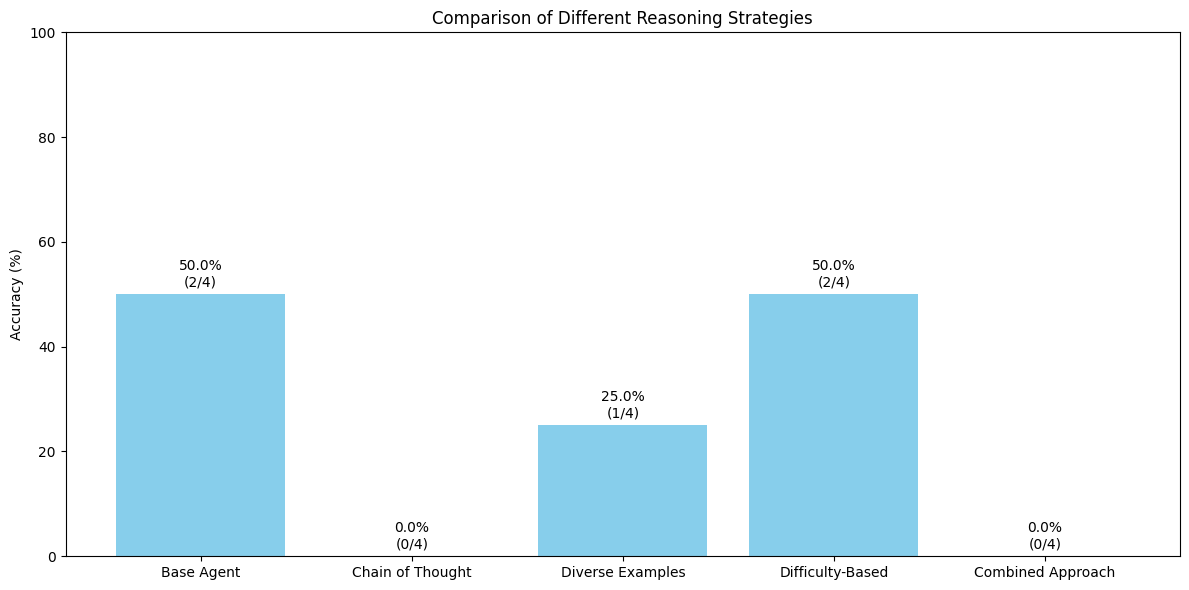

In [19]:

enhanced_agent = EnhancedReasoningAgent(
    tokenizer=tokenizer,
    model=model,
    db_texts=puzzles_texts,
    db_answers=puzzles_answers,
    db_embeddings=puzzles_embeddings,
    ollama_model="mistral",
    use_chain_of_thought=True,
    few_shot_strategy="diverse",
    strategy_params={"diversity_factor": 0.7}
)

test_query = "Jeśli 5 kotów łapie 5 myszy w 5 minut, ile myszy złapie 15 kotów w 15 minut?"
print("Chain of Thought reasoning with diverse examples:")
enhanced_agent.solve(test_query, verbose=True)

print("\nComparing different strategies...")
comparison_results = compare_agent_strategies(
    puzzles_df.sample(20),  # Use a smaller sample for quicker comparison
    tokenizer, 
    model, 
    puzzles_embeddings
)

plot_comparison_results(comparison_results)